# Gene Set Enrichment Analysis of Perturbed Target Genes

Loading the necessary R packages, loading my dataset, and filtering assigned_merged object for only cells that where identifed as Perturbed by Mixscapes. 

In [7]:
# Data Cleaning packages
library(enrichR)
library(tidytext)
library(gridExtra)
library(tidyverse)
library(data.table)
library(hrbrthemes)
library(RColorBrewer)
library(org.Hs.eg.db)
library(clusterProfiler)

data_dir = '../data'
hallmark = read.gmt('../data/h.all.v7.4.symbols.gmt')

In [8]:
yuza = readRDS(paste0(data_dir, '/SCE/Yuza_mixscape.Rds'))
edwards = readRDS(paste0(data_dir, '/SCE/Edwards_mixscape.Rds'))
brunello = readRDS(paste0(data_dir, '/SCE/Brunello_mixscape.Rds'))
merged = readRDS(paste0(data_dir, '/SCE/Merged_mixscape.Rds'))

yuza_res = readRDS(paste0(data_dir, '/DEGs/results/Yuza.Rds'))
edwards_res = readRDS(paste0(data_dir, '/DEGs/results/Edwards.Rds'))
brunello_res = readRDS(paste0(data_dir, '/DEGs/results/Brunello.Rds'))
merged_res = readRDS(paste0(data_dir, '/DEGs/results/Merged.Rds'))

# extracting gene metadata
gene_metadata = read.csv(paste0(data_dir, '/Metadata/gene_metadata.csv'))
rownames(gene_metadata) = gene_metadata$Gene.Symbol
colnames(gene_metadata) = c("Gene_Symbol", "Category", "Essentiality")

In [44]:
temp <- merged_res$ESR1 %>% 
            as.data.frame %>%
            filter(!is.na(padj) & padj <= 0.05) %>% 
            arrange(stat)

In [45]:
# utility functions to count degs in dea results and conduct gene set enrichment analysis
deg_count = function (results, ko_genes) {
    gene_names = c()
    deg_counts = c()

    for (gene in names(results)){
    
        if (!gene %in% ko_genes){
            next()
        }
        
        res = results[[gene]]

        res$padj[is.na(res$padj)] = 1
        qc_count = nrow(res[res$padj <= 0.05, ])

        gene_names = c(gene_names, gene)
        deg_counts = c(deg_counts, qc_count)
    }

    gene_deg_count = data.frame(deg_count = deg_counts, genes=gene_names)
    rownames(gene_deg_count) = gene_deg_count$genes
    
    return (gene_deg_count)
}

conduct_gsea = function (gene_res, ko_genes, hallmark, regulated='None', thresh=0.05, min_target_gene=20) {
    gses = list()
    dot_plots = list()
    cnet_plots = list()

    for (target_gene in names(gene_res)) {
        
        if (!target_gene %in% ko_genes){
            next()
        }
        
        gene_df = gene_res[[target_gene]] %>% 
                    as.data.frame %>% 
                    mutate(padj=ifelse(is.na(padj), 1, padj)) %>% 
                    filter(padj <= 0.05) %>%
                    arrange(stat)

        if (nrow(gene_df) < min_target_gene) {
            message (paste0("Skipping Target Gene ", target_gene,'...'))
            next()
        }
        
        gene_list = gene_df$stat * -1
        names(gene_list) = rownames(gene_df)
        
        message (paste0('Conducting Gene Set Enrichment Analysis ', target_gene, '...'))
        gse = GSEA(geneList=gene_list, verbose=TRUE, TERM2GENE=hallmark, pAdjustMethod = "none")
        
        if(nrow(gse) == 0){
            message (paste0("No Enriched Pathways Detected for Target Gene: ", target_gene,'...'))
            next()
        }
        gses[[target_gene]] = gse
        dot_plots[[target_gene]] = dotplot(gse) + 
                                        xlim(0, 1) + 
                                        theme(plot.margin = unit(c(0,0,0,0), "in")) +
                                        ggtitle(paste("GSEA for Target Gene:", target_gene))
        
        cnet_plots[[target_gene]] = cnetplot(gse, foldChange=gene_list, 
                                             circular = TRUE, colorEdge = TRUE)
    }

    return (list(gses=gses, dotplot=dot_plots, cnetplot=cnet_plots))
}

filter_res_df = function(dat, thresh=0.05, downreg_only=FALSE){
    dat = dat %>%
            as.data.frame %>%
            dplyr::mutate(gene_symbol = rownames(.)) %>%
            dplyr::filter(!is.na(padj) & padj <= thresh) %>%
            dplyr::arrange(desc(log2FoldChange))
    
    if (downreg_only) {
        dat = dat %>% dplyr::filter(log2FoldChange <= 0)
    }
    
    return (dat)
}

merge_dotplots <- function(reg_gsea_plot) {
    index <- c()
    reg_df <- list()

    for (gene in names(reg_gsea_plot$gses)) {
        df <- fortify(reg_gsea_plot$gses[[gene]], showCategory = 10)
        df$gene <- gene
        reg_df[[gene]] <- df
    }

    reg_df <- reg_df %>% bind_rows() %>% mutate(Description=gsub('HALLMARK_', '', Description))
    return (reg_df)
}

In [16]:
options(repr.plot.width=10, repr.plot.height=10)
genes_of_interest = c('MYC', 'MTOR', 'ESR1', 'FOXA1', 'GATA3', 'TFAP2C')
up_reg_gsea_plot = conduct_gsea(merged_res, genes_of_interest, hallmark, 'up')
down_reg_gsea_plot = conduct_gsea(merged_res, genes_of_interest, hallmark, 'down')

Conducting Gene Set Enrichment Analysis ESR1...

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...

Conducting Gene Set Enrichment Analysis MTOR...

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...

Conducting Gene Set Enrichment Analysis MYC...

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...

Conducting Gene Set Enrichment Analysis TFAP2C...

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...

Conducting Gene Set Enrichment Analysis FOXA1...

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...

Conducting Gene Set Enrichment Analysis GATA3...

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...

Conducting Gene 

In [17]:
options(repr.plot.width=25, repr.plot.height=25)

up_reg_df <- merge_dotplots(up_reg_gsea_plot)
down_reg_df <- merge_dotplots(down_reg_gsea_plot)

down_reg_plot <- down_reg_df %>% 
                    ggplot(aes(x=GeneRatio, y=reorder_within(Description, GeneRatio, gene) , size=Count, color=p.adjust)) + 
                    geom_point() +
                    scale_color_continuous(low="red", high="blue", name="p.adjust", guide=guide_colorbar(reverse=TRUE)) +
                    theme(aspect.ratio = 1,
                          plot.background = element_blank(),
                          panel.grid.major = element_blank(),
                          panel.grid.minor = element_blank(),
                          panel.border = element_blank(),
                          axis.line = element_line(color = 'black')) +
                    ylab('Hallmark Gene Sets') +
                    scale_size(range=c(3, 8)) +
                        guides(size  = guide_legend(order = 1), 
                               color = guide_colorbar(order = 2)) +
                    facet_wrap(~ gene, scales = "free_y")

up_reg_plot <- up_reg_df %>% 
                    ggplot(aes(x=GeneRatio, y=reorder_within(Description, GeneRatio, gene) , size=Count, color=p.adjust)) + 
                    geom_point() +
                    scale_color_continuous(low="red", high="blue", name="p.adjust", guide=guide_colorbar(reverse=TRUE)) +
                    theme(aspect.ratio = 1,
                          plot.background = element_blank(),
                          panel.grid.major = element_blank(),
                          panel.grid.minor = element_blank(),
                          panel.border = element_blank(),
                          axis.line = element_line(color = 'black')) + 
                    ylab('Hallmark Gene Sets') +
                    scale_size(range=c(3, 8)) +
                        guides(size  = guide_legend(order = 1), 
                               color = guide_colorbar(order = 2)) +
                    facet_wrap(~ gene, scales = "free_y")

# ggsave(paste0('up_dotplots.eps'), plot=up_reg_plot, height=25, width=25, unit="in", device = "eps")
# ggsave(paste0('down_dotplots.eps'), plot=down_reg_plot, height=25, width=25, unit="in", device = "eps")

## Deg Count Barplot

Counting the number of differentially expressed genes for a given target gene. These figures are counting differentially expressed genes with a **adjusted p-value < 0.05**.

In [18]:
yuza_ko_genes = yuza[[]] %>% filter(mixscape_class.global == 'KO') %>% pull(gene) %>% unique()
edwards_ko_genes = edwards[[]] %>% filter(mixscape_class.global == 'KO') %>% pull(gene) %>% unique()
brunello_ko_genes = brunello[[]] %>% filter(mixscape_class.global == 'KO') %>% pull(gene) %>% unique()

In [19]:
options(repr.plot.width=20, repr.plot.height=10)

yuza_deg_count = deg_count(yuza_res, yuza_ko_genes)
edwards_deg_count = deg_count(edwards_res, edwards_ko_genes)
brunello_deg_count = deg_count(brunello_res, brunello_ko_genes)

yuza_deg_plot = ggplot(yuza_deg_count, aes(x=reorder(genes, deg_count), y=deg_count)) +
                  geom_col(stat="identity", position=position_dodge()) +
                  ylim(0, 450) + coord_flip() + 
                  labs(x='Target Genes', y='Number of Detected DEGs',
                       title='Number of DEGs Detected for the Yuza Library')

edwards_deg_plot = ggplot(edwards_deg_count, aes(x=reorder(genes, deg_count), y=deg_count)) +
                  geom_col(stat="identity", position=position_dodge()) +
                  ylim(0, 450) + coord_flip() + 
                  labs(x='Target Genes', y='Number of Detected DEGs',
                       title='Number of DEGs Detected for the Edwards Library')

brunello_deg_plot = ggplot(brunello_deg_count, aes(x=reorder(genes, deg_count), y=deg_count)) +
                      geom_col(stat="identity", position=position_dodge()) +
                      ylim(0, 450) + coord_flip() + 
                      labs(x='Target Genes', y='Number of Detected DEGs',
                           title='Detected DEG Count for the Brunello Library')

Warning message:
“Ignoring unknown parameters: stat”
Warning message:
“Ignoring unknown parameters: stat”
Warning message:
“Ignoring unknown parameters: stat”


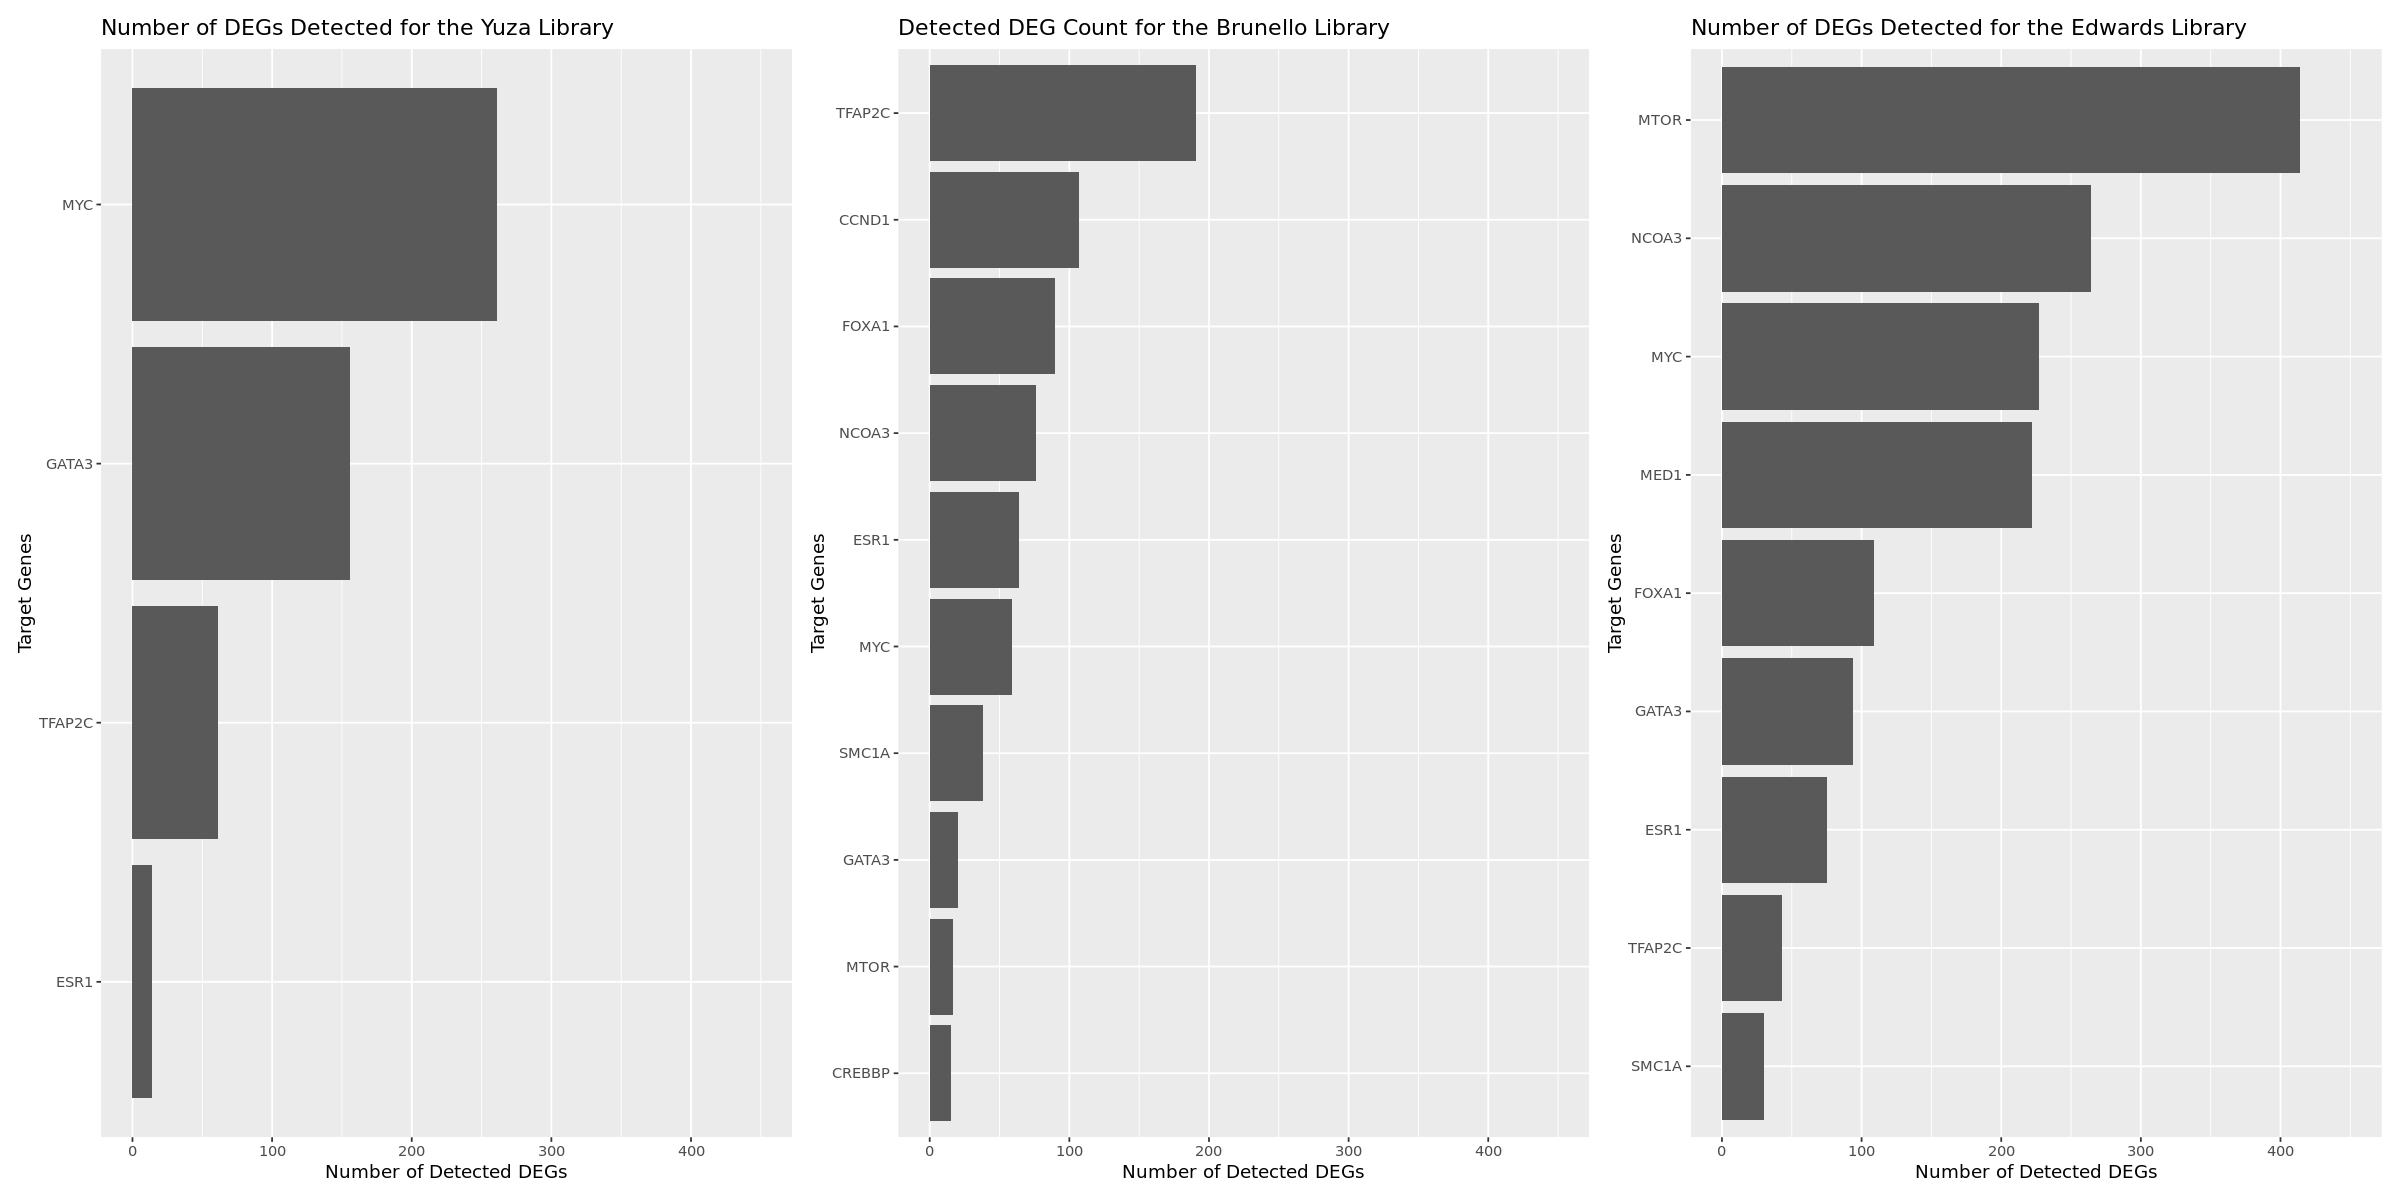

In [20]:
yuza_deg_plot | brunello_deg_plot | edwards_deg_plot

# Gene Set Enrichment Analysis of gRNA Libraries

Conducting Gene Set Enrichment Analysis of target genes that where identified to be perturbed by MixScape. This analysis was conducted on the individual library level as such there will be varying numbers of Target Genes being analyzed.

In [21]:
options(repr.plot.width=30, repr.plot.height=30)

edwards_gsea_plot = conduct_gsea(edwards_res, edwards_ko_genes, hallmark)
brunello_gsea_plot = conduct_gsea(brunello_res, brunello_ko_genes, hallmark)

Conducting Gene Set Enrichment Analysis MTOR...

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...

Conducting Gene Set Enrichment Analysis MYC...

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...

Conducting Gene Set Enrichment Analysis MED1...

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...

Conducting Gene Set Enrichment Analysis ESR1...

preparing geneSet collections...

GSEA analysis...

no term enriched under specific pvalueCutoff...

No Enriched Pathways Detected for Target Gene: ESR1...

Conducting Gene Set Enrichment Analysis SMC1A...

preparing geneSet collections...

GSEA analysis...

no term enriched under specific pvalueCutoff...

No Enriched Pathways Detected for Target Gene: SMC1A...

Conducting Gene Set Enrichment Analysis GATA3...

preparing geneSet collections...

GSEA analysis...

no term enriched under specific pvalueCutoff...

No Enriched Pathways Detecte

## DEGs shared with other Libraries vs Edwards unique DEGs

In [35]:
selecting_degs = function(dat, degs, shared=TRUE){
    
    if (shared == TRUE){
        dat = dat %>%
            filter(gene_symbol %in% degs) %>%
            arrange(desc(log2FoldChange))
    } else {
        dat = dat %>%
            filter(!gene_symbol %in% degs) %>%
            arrange(desc(log2FoldChange))
    }
    
    dat_degs = dat$log2FoldChange
    names(dat_degs) = dat$gene_symbol
    
    return (dat_degs)
}

generate_dotplot = function(gse, target_gene){
    gse_plot = dotplot(gse, split=".sign") + 
                    facet_grid(.~.sign) +
                    ggtitle(paste("GSEA for Target Gene:", target_gene))
    
    return (gse_plot)
}

In [63]:
edwards_unique_plots = list()
brunello_unique_plots = list()
brunello_edwards_plots = list()

for (target_gene in edwards_ko_genes) {
    edwards_df = edwards_res[[target_gene]]
    brunello_df = brunello_res[[target_gene]]
    
    # filtering degs
    edwards_df = filter_res_df(edwards_df)
    brunello_df = filter_res_df(brunello_df)
    
    if (nrow(edwards_df) == 0 || nrow(brunello_df) == 0) {
        next()
    }
    
    # finding overlapping differentially expressed genes
    brunello_edwards_degs = intersect(edwards_df$gene_symbol, brunello_df$gene_symbol)
    
    # selecting degs and log2FoldChange for GSEA
    brunello_edwards = selecting_degs(edwards_df, brunello_edwards_degs)
    edwards_unique = selecting_degs(edwards_df, brunello_df$gene_symbol, shared=FALSE)
    brunello_unique = selecting_degs(brunello_df, edwards_df$gene_symbol, shared=FALSE)
    
    # conduct GSEA
    brunello_edwards_gse = GSEA(geneList=brunello_edwards, verbose=TRUE, TERM2GENE=hallmark, pAdjustMethod = "none")
    edwards_unique_gse = GSEA(geneList=edwards_unique, verbose=TRUE, TERM2GENE=hallmark, pAdjustMethod = "none")
    brunello_unique_gse = GSEA(geneList=brunello_unique, verbose=TRUE, TERM2GENE=hallmark, pAdjustMethod = "none")

    if(nrow(brunello_edwards_gse) == 0) {
            message (paste0("No Enriched Pathways Detected for DEGs Intersect Brunello and Edwards Target Gene: ", target_gene,'...'))
    } else {
        brunello_edwards_plots[[target_gene]] = generate_dotplot(brunello_edwards_gse, target_gene)
    }

    if(nrow(edwards_unique_gse) == 0) {
            message (paste0("No Enriched Pathways Detected for Degs Unique to Edwards Target Gene: ", target_gene,'...'))
    } else {
        edwards_unique_plots[[target_gene]] = generate_dotplot(edwards_unique_gse, target_gene)
    }
    
    if(nrow(brunello_unique_gse) == 0) {
            message (paste0("No Enriched Pathways Detected for Degs Unique to Brunello Target Gene: ", target_gene,'...'))
    } else {
        brunello_unique_plots[[target_gene]] = generate_dotplot(brunello_unique_gse, target_gene)
    }
    
}

preparing geneSet collections...

GSEA analysis...

no term enriched under specific pvalueCutoff...

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“All values in the stats vector are greater than zero and scoreType is "std", maybe you should switch to scoreType = "pos".”
no term enriched under specific pvalueCutoff...

No Enriched Pathways Detected for DEGs Intersect Brunello and Edwards Target Gene: MTOR...

No Enriched Pathways Detected for Degs Unique to Brunello Target Gene: MTOR...

preparing geneSet collections...

GSEA analysis...

no term enriched under specific pvalueCutoff...

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...

preparing geneSet collections...

GSEA analysis...

no term enriched under specific pvalueCutoff...

No Enriched Pathways Detected for 

## Edwards Unique GSEA

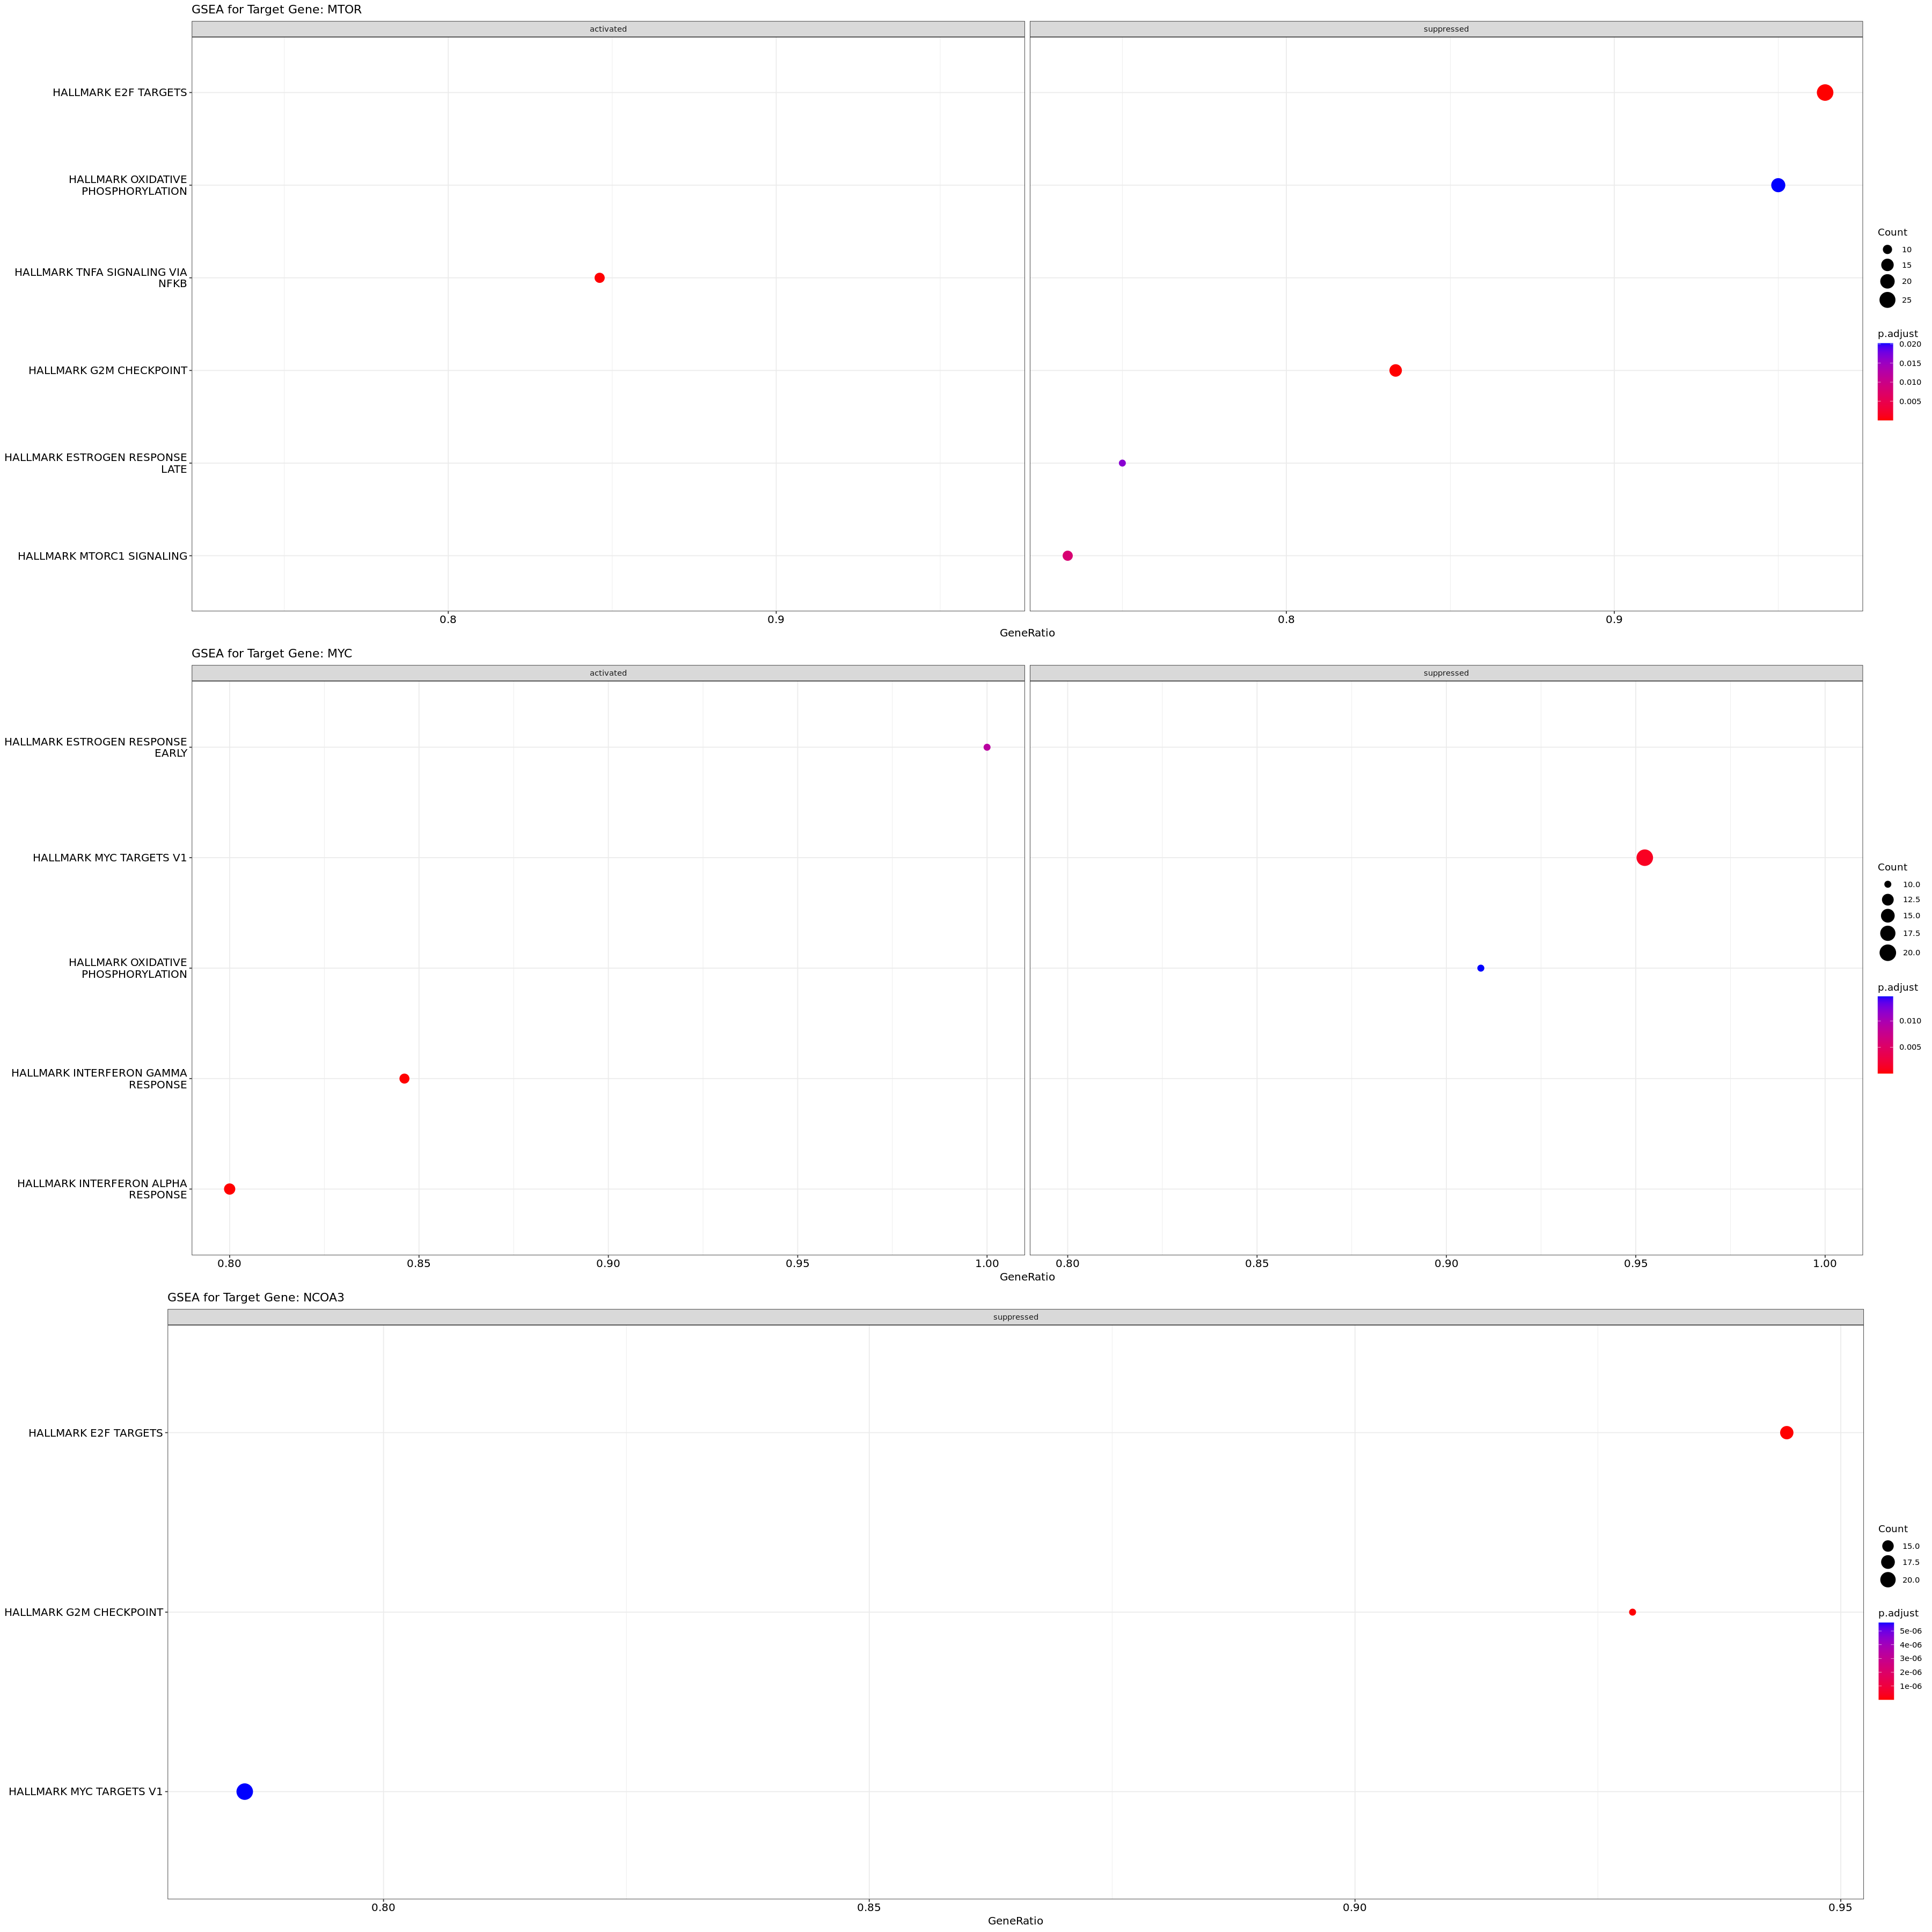

In [65]:
n = length(edwards_unique_plots)
nCol = floor(sqrt(n))
do.call("grid.arrange", c(edwards_unique_plots, ncol=nCol))

## Brunello Unique GSEA

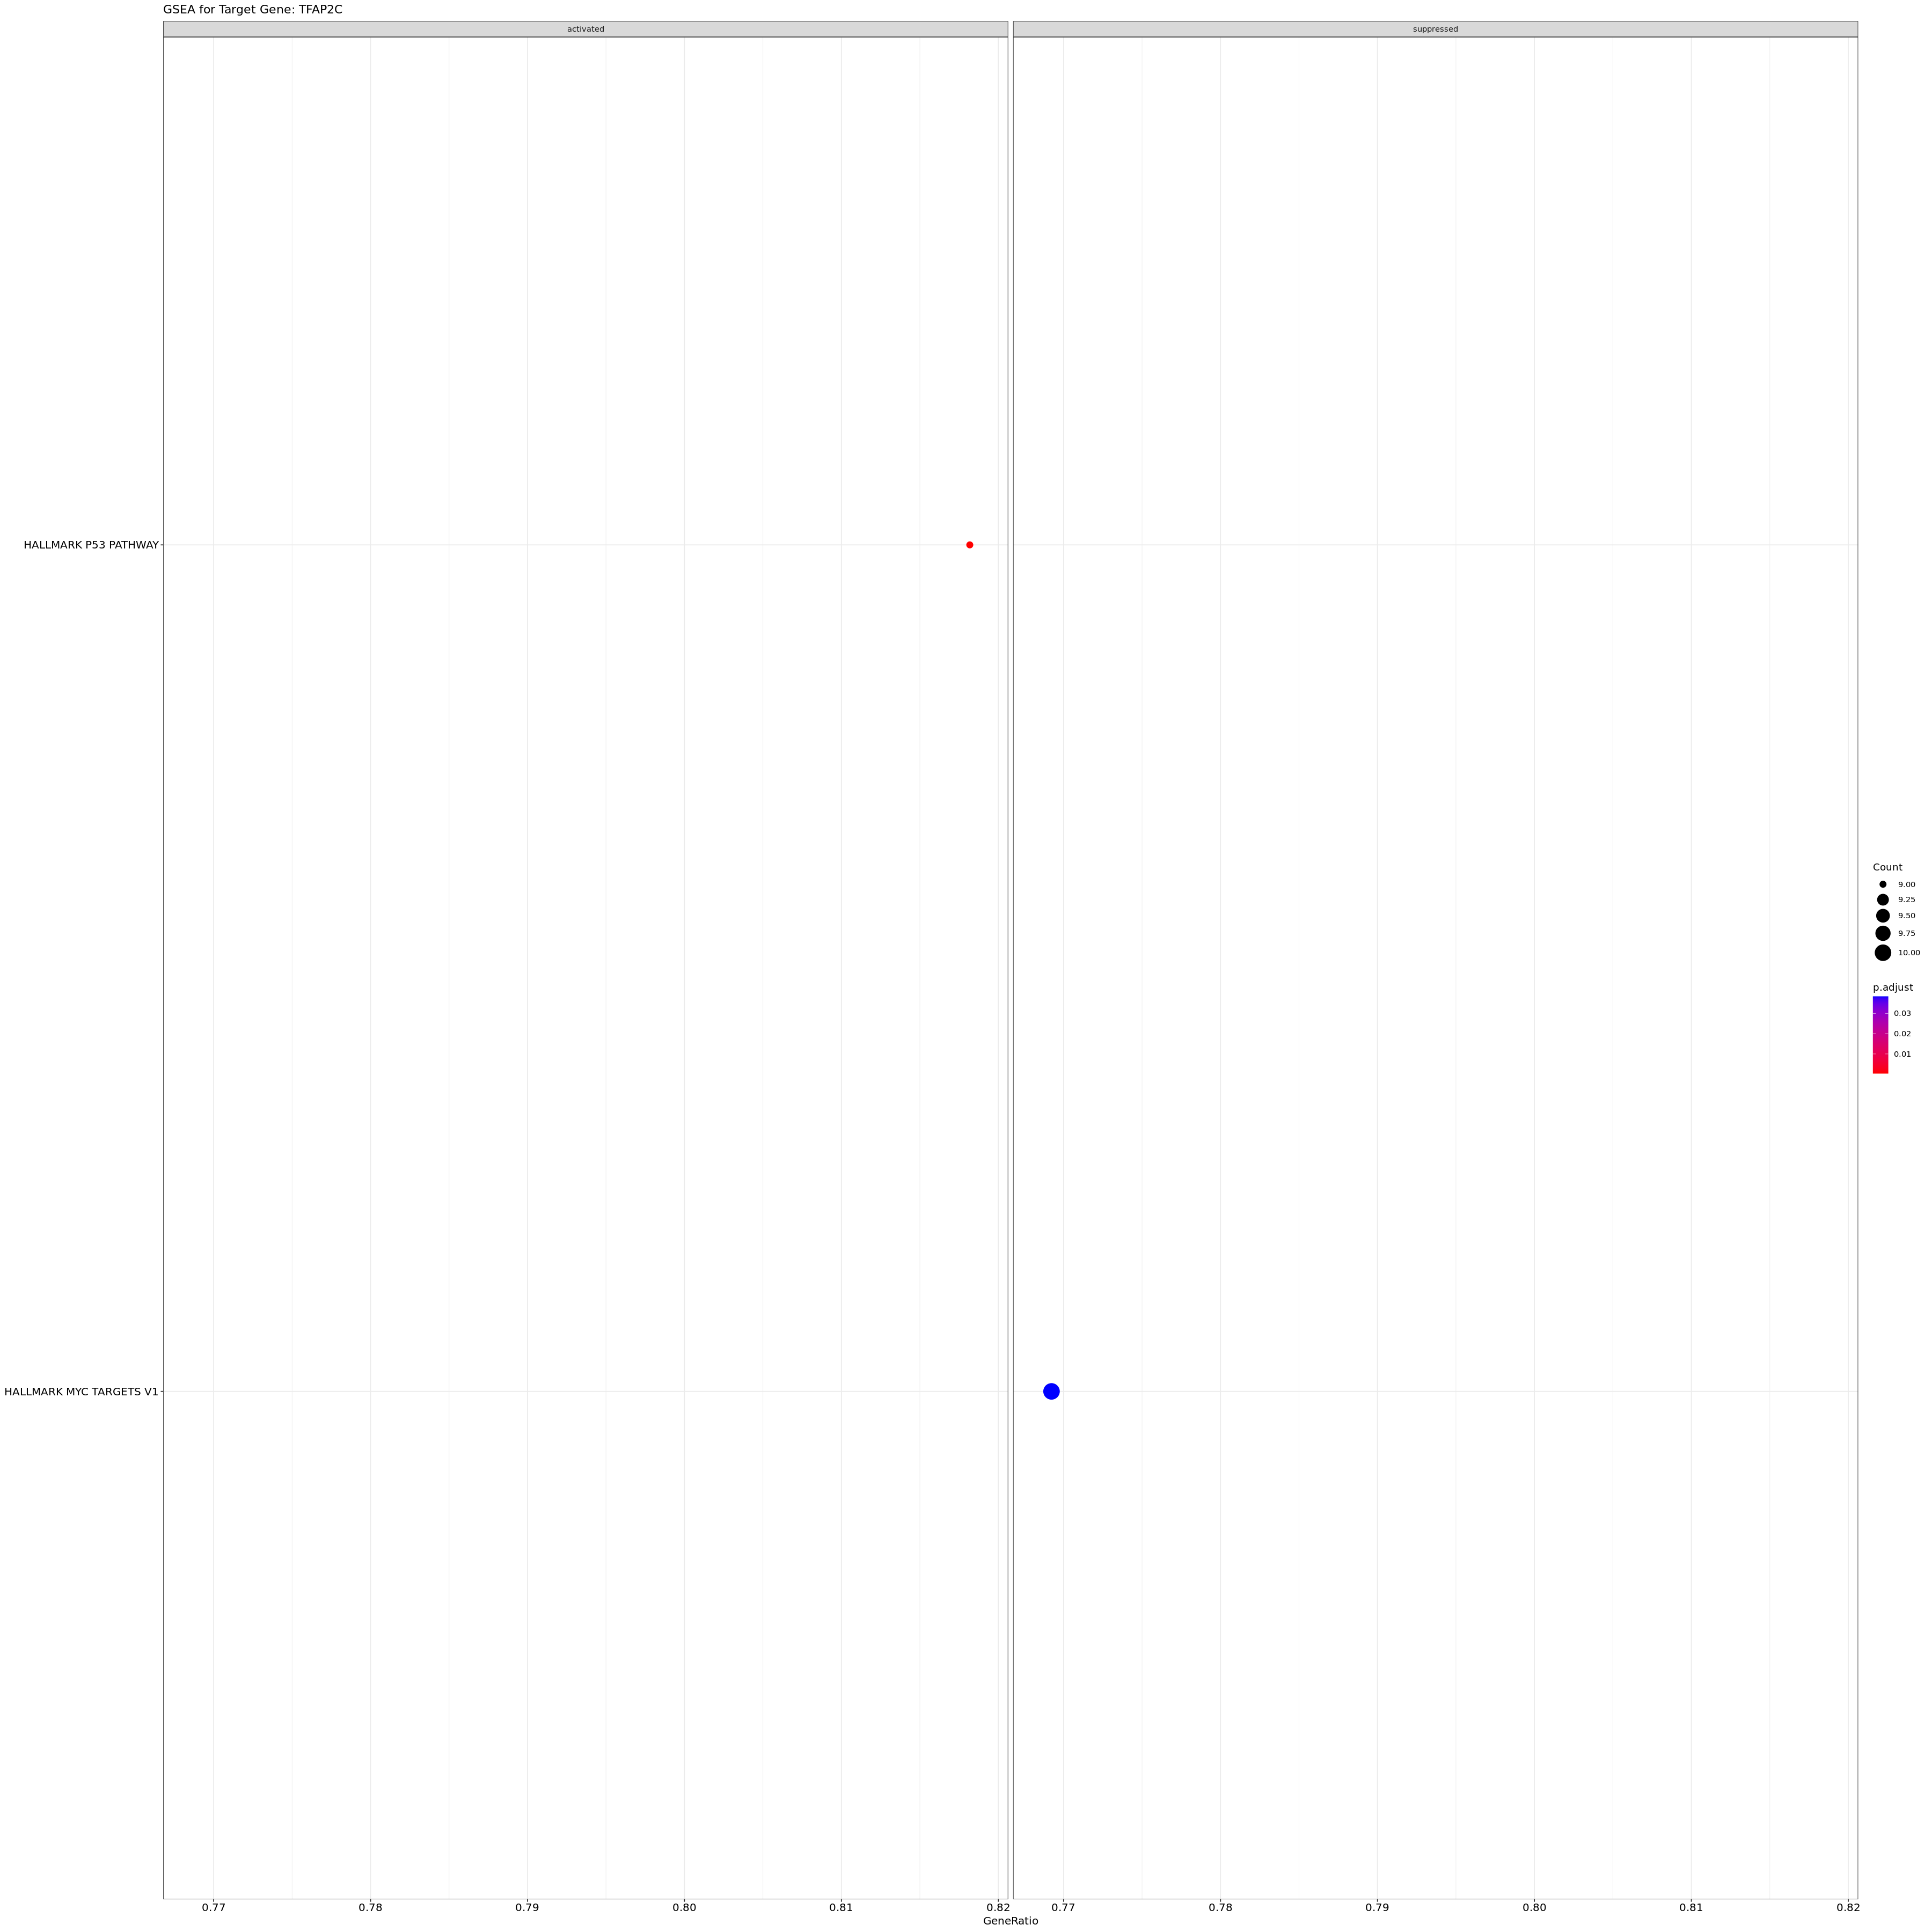

In [66]:
n = length(brunello_unique_plots)
nCol = floor(sqrt(n))
do.call("grid.arrange", c(brunello_unique_plots, ncol=nCol))

# Save Differential Expression Analysis per Target Gene per Library

In [16]:
degs_dir = '/scratchb/fmlab/baker02/Edwards/notebooks/data_and_figures/degs'

for (target_gene in edwards_ko_genes) {
    edwards_df = as.data.frame(edwards_res[[target_gene]])
    brunello_df = as.data.frame(brunello_res[[target_gene]])
    
    edwards_df = edwards_df %>% mutate(gene_symbol = rownames(.))
    brunello_df = brunello_df %>% mutate(gene_symbol = rownames(.))
    
    write.csv(edwards_df, file.path(degs_dir, paste0('edwards/edwards_', target_gene, '.csv')), row.names=FALSE)
    write.csv(brunello_df, file.path(degs_dir, paste0('brunello/brunello_', target_gene, '.csv')), row.names=FALSE)
}

# Enrichment Analysis HallMark GeneSet

In [9]:
dbs <- listEnrichrDbs()

In [10]:
merged_myc_degs <- merged_res[['MYC']] %>% as.data.frame %>% filter(!is.na(padj) & padj <= 0.05) %>% rownames()
merged_mtor_degs <- merged_res[['MTOR']] %>% as.data.frame %>% filter(!is.na(padj) & padj <= 0.05) %>% rownames()
merged_esr1_degs <- merged_res[['ESR1']] %>% as.data.frame %>% filter(!is.na(padj) & padj <= 0.05) %>% rownames()
merged_ncoa3_degs <- merged_res[['NCOA3']] %>% as.data.frame %>% filter(!is.na(padj) & padj <= 0.05) %>% rownames()
merged_foxa1_degs <- merged_res[['FOXA1']] %>% as.data.frame %>% filter(!is.na(padj) & padj <= 0.05) %>% rownames()
merged_tfap2c_degs <- merged_res[['TFAP2C']] %>% as.data.frame %>% filter(!is.na(padj) & padj <= 0.05) %>% rownames()
merged_gata3_degs <- merged_res[['GATA3']] %>% as.data.frame %>% filter(!is.na(padj) & padj <= 0.05) %>% rownames()

edwards_mtor_degs <- edwards_res[['MTOR']] %>% as.data.frame %>% filter(!is.na(padj) & padj <= 0.05) %>% rownames()
edwards_ncoa3_degs <- edwards_res[['NCOA3']] %>% as.data.frame %>% filter(!is.na(padj) & padj <= 0.05) %>% rownames()

Loading required package: DESeq2

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeig

In [11]:
temp <- edwards_mtor_degs[!edwards_mtor_degs %in% merged_mtor_degs]
write(temp, "edwards_unique_mtor_degs.txt")

temp <- edwards_ncoa3_degs[!edwards_ncoa3_degs %in% merged_ncoa3_degs]
write(temp, "edwards_unique_ncoa3_degs.txt")

In [12]:
merged_myc_enriched <- enrichr(merged_myc_degs, c("MSigDB_Hallmark_2020"))[[1]] %>% filter(Adjusted.P.value <= 0.05) %>% rowwise %>% mutate(Count=length(str_split(Genes[1],  ";")[[1]])) %>% as.data.frame
merged_mtor_enriched <- enrichr(merged_mtor_degs, c("MSigDB_Hallmark_2020"))[[1]] %>% filter(Adjusted.P.value <= 0.05) %>% rowwise %>% mutate(Count=length(str_split(Genes[1],  ";")[[1]])) %>% as.data.frame
merged_esr1_enriched <- enrichr(merged_esr1_degs, c("MSigDB_Hallmark_2020"))[[1]] %>% filter(Adjusted.P.value <= 0.05) %>% rowwise %>% mutate(Count=length(str_split(Genes[1],  ";")[[1]])) %>% as.data.frame
merged_ncoa3_enriched <- enrichr(merged_ncoa3_degs, c("MSigDB_Hallmark_2020"))[[1]] %>% filter(Adjusted.P.value <= 0.05) %>% rowwise %>% mutate(Count=length(str_split(Genes[1],  ";")[[1]])) %>% as.data.frame
merged_foxa1_enriched <- enrichr(merged_foxa1_degs, c("MSigDB_Hallmark_2020"))[[1]] %>% filter(Adjusted.P.value <= 0.05) %>% rowwise %>% mutate(Count=length(str_split(Genes[1],  ";")[[1]])) %>% as.data.frame
merged_tfap2c_enriched <- enrichr(merged_tfap2c_degs, c("MSigDB_Hallmark_2020"))[[1]] %>% filter(Adjusted.P.value <= 0.05) %>% rowwise %>% mutate(Count=length(str_split(Genes[1],  ";")[[1]])) %>% as.data.frame
merged_gata3_enriched <- enrichr(merged_gata3_degs, c("MSigDB_Hallmark_2020"))[[1]] %>% filter(Adjusted.P.value <= 0.05) %>% rowwise %>% mutate(Count=length(str_split(Genes[1],  ";")[[1]])) %>% as.data.frame

edwards_mtor_enriched <- enrichr(edwards_mtor_degs, c("MSigDB_Hallmark_2020"))[[1]] %>% filter(Adjusted.P.value <= 0.05) %>% rowwise %>% mutate(Count=length(str_split(Genes[1],  ";")[[1]])) %>% as.data.frame
edwards_ncoa3_enriched <- enrichr(edwards_ncoa3_degs, c("MSigDB_Hallmark_2020"))[[1]] %>% filter(Adjusted.P.value <= 0.05) %>% rowwise %>% mutate(Count=length(str_split(Genes[1],  ";")[[1]])) %>% as.data.frame

Uploading data to Enrichr... Done.
  Querying MSigDB_Hallmark_2020... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying MSigDB_Hallmark_2020... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying MSigDB_Hallmark_2020... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying MSigDB_Hallmark_2020... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying MSigDB_Hallmark_2020... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying MSigDB_Hallmark_2020... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying MSigDB_Hallmark_2020... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying MSigDB_Hallmark_2020... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying MSigDB_Hallmark_2020... Done.
Parsing results... Done.


In [13]:
plot_go_enrichment <- function(df, showTerms = 20, numChar = 40, y = "Count", fillBy='Adjusted.P.value', xlab = NULL, ylab = NULL, title = NULL) {

    if(!is.numeric(numChar)) {
        stop(paste0("numChar '", numChar, "' is invalid."))
    }

    # Create trimmed name (as seen in topGO)
    df <- df[order(df$Count, decreasing=TRUE), ]
    map <- aes_string(x = "shortName", y = y, fill = fillBy)
    
    shortName <- paste(substr(df$Term, 1, numChar), ifelse(nchar(df$Term) > numChar, '...', ''), sep = '')
    df$shortName <- factor(shortName, levels=shortName)
    
    # Define y variable (Count or Ratio)
    if(y != "Ratio") {
        y <- "Significant"
    }

    # Define labels
    if(is.null(xlab)) {
        xlab <- "Enriched terms"
    }

    if(is.null(ylab)) {
        ylab <- "Gene count"
    }

    if(is.null(title)) {
        title <- "Enrichment analysis by Enrichr"
    }

    # Make the ggplot
    p <- ggplot(df, map) +
            geom_bar(stat = "identity") +
            coord_flip() + 
            theme_bw() + 
            scale_fill_continuous(low = "red", high = "blue") +
            scale_x_discrete(limits = rev(levels(df$shortName))) +
            guides(fill = guide_colorbar(title = "Adjusted P-Value", reverse = TRUE)) +
            theme(axis.text.x = element_text(colour = "black", vjust = 1),
                   axis.text.y = element_text(colour = "black", hjust = 1),
                   axis.title = element_text(color = "black", margin = margin(10, 5, 0, 0)),
                   axis.title.y = element_text(angle = 90)) + 
            xlab(xlab) + 
            ylab(ylab) + 
            ggtitle(title)

    return(p)
}


In [14]:
merged_myc_plot <- plot_go_enrichment(merged_myc_enriched, showTerms = 20, numChar = 40, y = "Count") +
                            theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
merged_mtor_plot <- plot_go_enrichment(merged_mtor_enriched, showTerms = 20, numChar = 40, y = "Count") +
                            theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
merged_esr1_plot <- plot_go_enrichment(merged_esr1_enriched, showTerms = 20, numChar = 40, y = "Count") +
                            theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
merged_ncoa3_plot <- plot_go_enrichment(merged_ncoa3_enriched, showTerms = 20, numChar = 40, y = "Count") +
                            theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
merged_foxa1_plot <- plot_go_enrichment(merged_foxa1_enriched, showTerms = 20, numChar = 40, y = "Count") +
                            theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
merged_tfapc2_plot <- plot_go_enrichment(merged_tfap2c_enriched, showTerms = 20, numChar = 40, y = "Count") +
                            theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
merged_gata3_plot <- plot_go_enrichment(merged_gata3_enriched, showTerms = 20, numChar = 40, y = "Count") +
                            theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())


edwards_mtor_plot <- plot_go_enrichment(edwards_mtor_enriched, showTerms = 20, numChar = 40, y = "Count") +
                            theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
edwards_ncoa3_plot <- plot_go_enrichment(edwards_ncoa3_enriched, showTerms = 20, numChar = 40, y = "Count")+
                            theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

In [ ]:
ggsave("merged_myc_go_enrichment.eps", plot=merged_myc_plot, height=6, width=6, units="in",device = "eps")
ggsave("merged_mtor_go_enrichment.eps", plot=merged_mtor_plot, height=6, width=6, units="in",device = "eps")
ggsave("merged_esr1_go_enrichment.eps", plot=merged_esr1_plot, height=6, width=6, units="in",device = "eps")
ggsave("merged_ncoa3_go_enrichment.eps", plot=merged_ncoa3_plot, height=6, width=6, units="in",device = "eps")
ggsave("merged_foxa1_go_enrichment.eps", plot=merged_foxa1_plot, height=6, width=6, units="in",device = "eps")
ggsave("merged_tfapc2_go_enrichment.eps", plot=merged_tfapc2_plot, height=6, width=6, units="in",device = "eps")
ggsave("merged_gata3_go_enrichment.eps", plot=merged_gata3_plot, height=6, width=6, units="in",device = "eps")

ggsave("edwards_mtor_go_enrichment.eps", plot=edwards_mtor_plot, height=6, width=6, units="in",device = "eps")
ggsave("edwards_ncoa3_go_enrichment.eps", plot=edwards_ncoa3_plot, height=6, width=6, units="in",device = "eps")